In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
import pandas as pd
from numba import njit
import scipy.special


### Layer builder function ###
def layer_builder(layer_n,layer_t,interface_rough,slice_t):
    # initialize arrays
    total_layer = []
    interfaces_idx = np.zeros(len(layer_t)-1)
    
    # assign interface indexes
    for i in range(len(layer_t)-1):
        interfaces_idx[i] = interfaces_idx[i-1] + int(layer_t[i]/slice_t)
        
    # create index of refraction array
    i = 0
    for filmt in layer_t:
        temp_layer = np.ones(int(filmt/slice_t))
        temp_layer = temp_layer*layer_n[i]
        total_layer = np.concatenate((total_layer,temp_layer))
        i = i + 1
    z = np.zeros((len(total_layer),1))
    
    # create depth position array
    for j in range(len(z)):
        z[j] = layer_t[0]-j*slice_t
        
    # incorporate surface roughness into array
    i = 0 # reset counter
    for rough in interface_rough:
        idx = int(interfaces_idx[i])
        if rough == 0:
            pass
        else:
            x = np.arange(-100,100,2)
            CDF = 1/2*(1 + scipy.special.erf(x/(rough*np.sqrt(2))))
            y_real = (total_layer[idx+1])*CDF + (total_layer[idx-1])*(1-CDF)
            total_layer[idx-50:idx+50] = y_real
        i = i+1
    return z, total_layer


### Reflectivity and EFI recursive calculation ###

# @njit - function decorator to use numba's just-in-time compiler. 
# The first time the function is run, it is slower because it needs to be compiled. For subsequent evaluations, it is faster than the uncompiled
# function.
### Function timing for alpha_i = np.arange(0.1,2,0.001) ###
# njit: 377 ms ± 6.88 ms 
# uncompiled: 435 ms +/- 4.35 ms

@njit 
def EFI_vec(wavelength, z_layers,n_layers,alpha_i):
    n_layers = n_layers.reshape(len(n_layers),1)
    z_layers = z_layers.reshape(len(z_layers),1)
    
    k0 = 2*np.pi/wavelength
    R = np.zeros((len(n_layers),len(alpha_i)),dtype=np.complex_)
    T = np.zeros((len(n_layers),len(alpha_i)),dtype=np.complex_)
    X = np.zeros((len(n_layers),len(alpha_i)),dtype=np.complex_)
    EFI = np.zeros((len(n_layers),len(alpha_i)))
    sigma = np.zeros((len(n_layers),1)) #unused - roughness is now in layer builder
    Rf = np.zeros((len(alpha_i),1),dtype=np.complex_)
    
    # z-component of wavevector
    kz = k0*np.sqrt(n_layers**2-np.cos(alpha_i)**2)
    
    r = ((kz[0:-1,:] - kz[1:len(n_layers)+1,:])/(kz[0:-1,:] + kz[1:len(n_layers)+1,:])
            *np.exp(-2*kz[0:-1,:]*kz[1:len(n_layers)+1,:]*sigma[0:-1]**2))# for reflectivity calculation
    
    # Recursion to calculate reflectivity at surface
    for i in range(len(n_layers)-2,-1,-1):
        X[i,:] = (np.exp(-2.j*kz[i,:]*z_layers[i]) * 
                (r[i,:]+X[i+1,:]*np.exp(2.j*kz[i+1,:]*z_layers[i])) / 
                (1+r[i,:]*X[i+1,:]*np.exp(2.j*kz[i+1,:]*z_layers[i])))
    
    Rf = X[0,:]
    R[0,:] = X[0,:]
    T[0,:] = 1
    # Recursion to calculate R, T in film and used to calculate EFI
    rj1j = ((kz[1:len(n_layers)+1,:] - kz[0:-1,:])/(kz[0:-1,:] + kz[1:len(n_layers)+1,:])*
            np.exp(-2*kz[0:-1,:]*kz[1:len(n_layers+1),:]*sigma[0:-1]**2))
    tj1j = (1 + rj1j)* np.exp((kz[1:len(n_layers+1),:]-kz[0:-1,:])**2*sigma[0:-1]**2/2)
    for i in range(0,len(n_layers)-1):
        R[i+1,:] = ((1/tj1j[i,:]) * 
                  (T[i,:]*rj1j[i,:]*np.exp(-1.j*(kz[i+1,:] + kz[i,:])*z_layers[i]) + 
                  R[i,:]*np.exp(-1.j*(kz[i+1,:] - kz[i,:])*z_layers[i])))
        T[i+1,:] = ((1/tj1j[i,:]) * 
                  (T[i,:]*np.exp(1.j*(kz[i+1,:] - kz[i,:])*z_layers[i]) + 
                  R[i,:]*rj1j[i,:]*np.exp(1.j*(kz[i+1,:] + kz[i,:])*z_layers[i])))
    R[-1,:] = 0
    ER = R*np.exp(1.j*kz*z_layers)
    ET = T*np.exp(-1.j*kz*z_layers)
#     print(ET.shape,ER.shape)
    EFI = (np.abs(ER + ET)**2)
    return Rf, EFI, R, T, ET, ER
    # Rf - reflected wave amplitude at top surface. Reflectivity = |Rf|^2
    # EFI - Electric Field Intensity EFI = |ER + ET|^2
    # R, T - reflected and transmitted wave amplitudes
    # ER, ET - reflected and transmitted waves

In [3]:
# Optical constants estimated from henke.lbl.gov at a wavelength of 1.54 Angstroms

# Polystyrene
delta_PS = 3.45346848E-06
beta_PS = 4.89482366E-09
n_PS = np.complex(1-delta_PS, beta_PS)

# Silicon
delta_Si = 7.57536282E-06
beta_Si = 1.72802345E-07
n_Si = np.complex(1-delta_Si, beta_Si)

# air (vacuum)
n_air = np.complex(1,0)

In [4]:
# Optical constants estimated from henke.lbl.gov for 9.2 keV

# Polystyrene
delta_PS = 2.77525828E-06
beta_PS = 2.9830387E-09
n_PS = np.complex(1-delta_PS, beta_PS)

# Silicon
delta_Si = 5.78539039E-06
beta_Si = 1.024234E-07
n_Si = np.complex(1-delta_Si, beta_Si)

# air (vacuum)
n_air = np.complex(1,0)
wvl = 1.3477 # angstroms

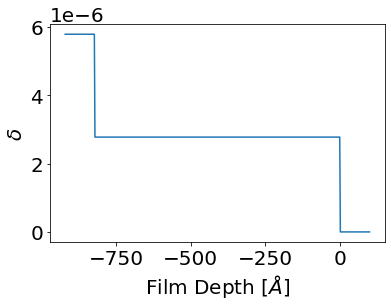

In [5]:
z_layers, n_layers = layer_builder((n_air, n_PS, n_Si),(100,824,100),(0,0),2) # n layers, n-1 interfaces
fig, ax = plt.subplots()
plt.plot(z_layers,1-np.real(n_layers))
plt.xlabel(r'Film Depth [$\AA$]')
plt.ylabel(r'$\delta$')
ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.show()

In [14]:
alpha_i = np.arange(0.1, 0.4, .005)/180*np.pi #input should be in radians
wavelength = 1.54 # angstroms
Rf, EFI, R, T, ET, ER = EFI_vec(wavelength, z_layers,n_layers,alpha_i)

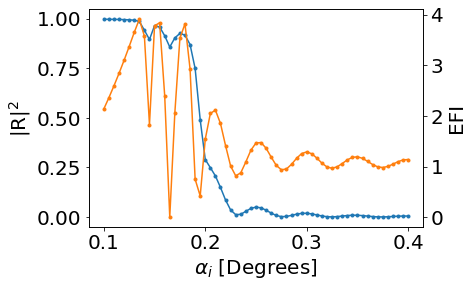

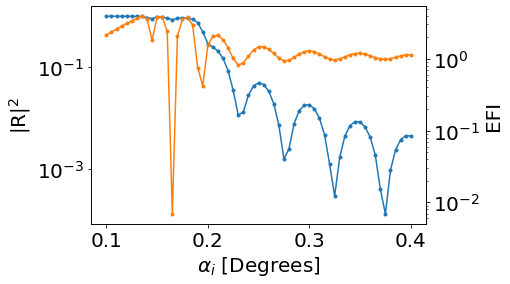

In [15]:
fig, ax = plt.subplots()
plt.plot(alpha_i/np.pi*180,np.abs(Rf)**2,'.-')
plt.ylabel(r'|R|$^2$')
ax2 = ax.twinx()
ax2.plot(alpha_i/np.pi*180,EFI[50,:],'.-',color='tab:orange')
ax2.set_ylabel('EFI')
ax.set_xlabel(r'$\alpha_i$ [Degrees]')
plt.show()

fig, ax = plt.subplots()
plt.semilogy(alpha_i/np.pi*180,np.abs(Rf)**2,'.-')
plt.ylabel(r'|R|$^2$')
ax2 = ax.twinx()
ax2.semilogy(alpha_i/np.pi*180,EFI[50,:],'.-',color='tab:orange')
ax2.set_ylabel('EFI')
ax.set_xlabel(r'$\alpha_i$ [Degrees]')
plt.show()

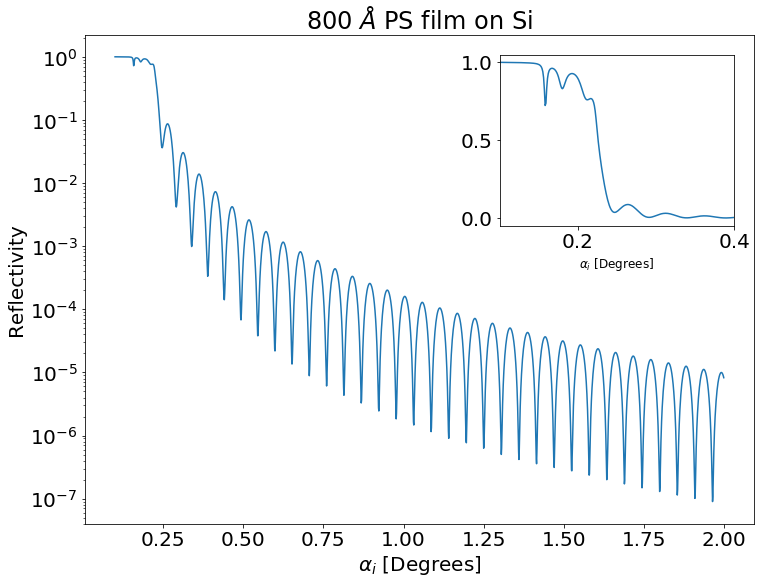

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(figsize=(12,9))
axin = inset_axes(ax,width='35%',height='35%',borderpad=1)
ax.semilogy(alpha_i/np.pi*180,np.abs(Rf)**2)
axin.plot(alpha_i/np.pi*180,np.abs(Rf)**2)
axin.set_xlim(0.1,0.4)
ax.set_xlabel(r'$\alpha_i$ [Degrees]')
ax.set_ylabel('Reflectivity')
axin.set_xlabel(r'$\alpha_i$ [Degrees]',fontsize=12)
ax.set_title(r'800 $\AA$ PS film on Si')
plt.show()

## Step Size Comparison

* The EFI_vec function has everything bundled in to one, which makes it slower for a large range of incidence angles. Eventually I'll split out the reflectivity and EFI calculations. But for EFI most of the modulation happens between $\alpha_c$ of the film and substrate, so you can go to finer steps in $\alpha_i$ and smaller $\alpha_i$ ranges

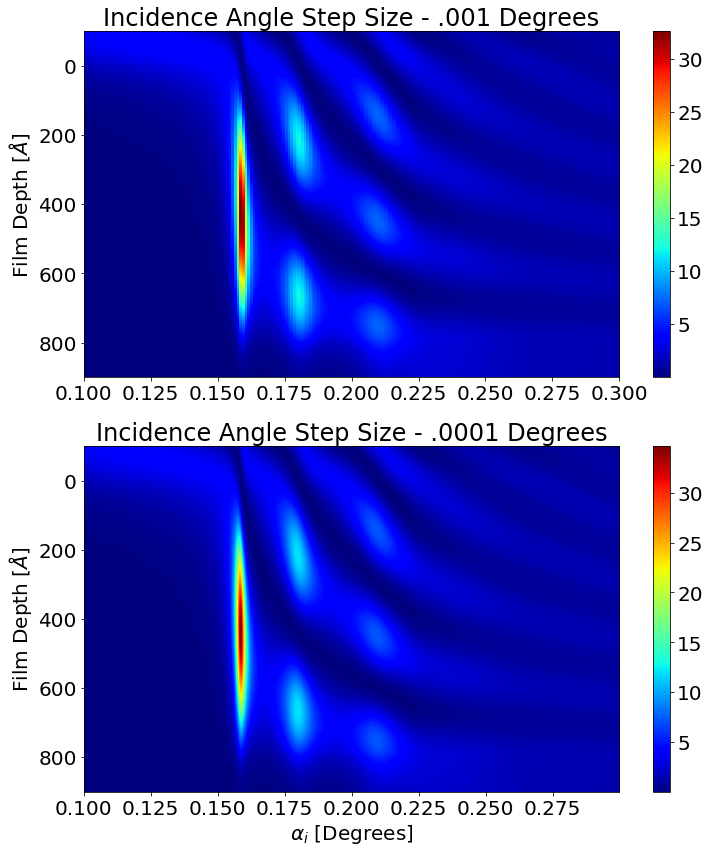

In [6]:
figure, ax = plt.subplots(2,1,figsize=(12,12))
plt.subplots_adjust(bottom=0)
e1 = ax[0].imshow(EFI,cmap='jet',aspect='auto',extent=[np.rad2deg(alpha_i[0]),np.rad2deg(alpha_i[-1]),900,-100])
ax[0].set_xlim(0.1,0.3)
# ax[0].set_xlabel(r'$\alpha_i$ [Degrees]')
ax[0].set_ylabel(r'Film Depth [$\AA$]')
ax[0].set_title('Incidence Angle Step Size - .001 Degrees')
plt.colorbar(e1,ax=ax[0])

alpha_fine = np.arange(0.1, .3, .0001)/180*np.pi #input should be in radians
_, EFI_fine, _, _, _, _ = EFI_vec(wavelength, z_layers,n_layers,alpha_fine)
# plt.figure(figsize=(12,9))
e2 = ax[1].imshow(EFI_fine,cmap='jet',aspect='auto',extent=[np.rad2deg(alpha_fine[0]),np.rad2deg(alpha_fine[-1]),900,-100])
# plt.xlim(0.1,0.3)
ax[1].set_xlabel(r'$\alpha_i$ [Degrees]')
ax[1].set_ylabel(r'Film Depth [$\AA$]')
ax[1].set_title('Incidence Angle Step Size - .0001 Degrees')
plt.colorbar(e2,ax=ax[1])
plt.show()

* This version also returns the various contributions to EFI in a couple different forms. It can be useful for visualization/understanding and for troubleshooting

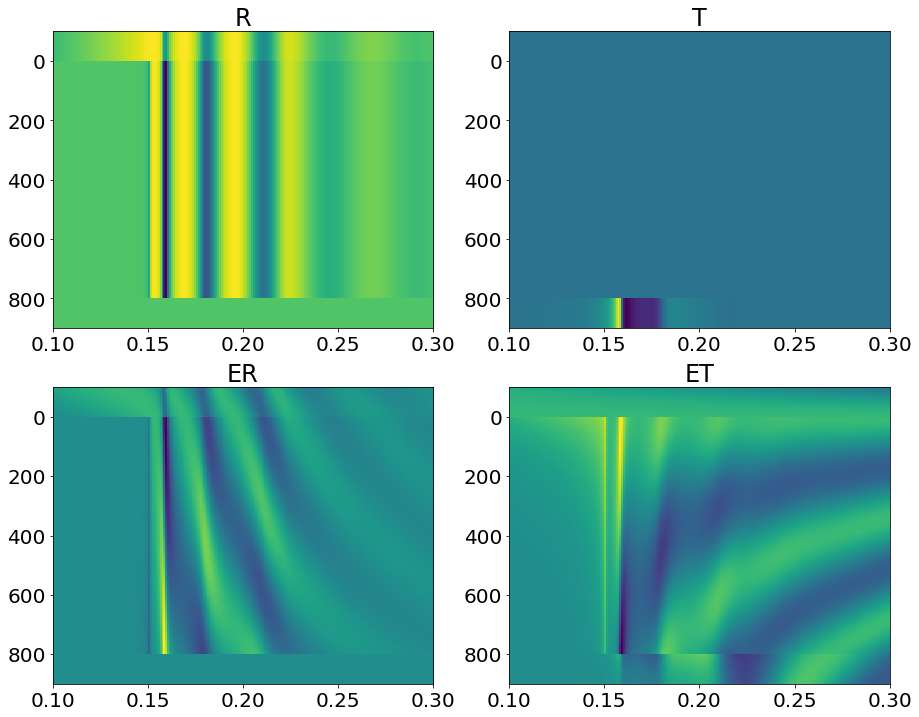

In [7]:
fig,ax = plt.subplots(2,2,figsize=(15,12))
ax[0,0].imshow(np.real(R[:,0:200]),aspect='auto',extent=[np.rad2deg(alpha_i[0]),np.rad2deg(alpha_i[200]),900,-100])
ax[0,0].set_title('R')
ax[0,1].imshow(np.real(T[:,0:200]),aspect='auto',extent=[np.rad2deg(alpha_i[0]),np.rad2deg(alpha_i[200]),900,-100])
ax[0,1].set_title('T')
ax[1,0].imshow(np.real(ER[:,0:200]),aspect='auto',extent=[np.rad2deg(alpha_i[0]),np.rad2deg(alpha_i[200]),900,-100])
ax[1,0].set_title('ER')
ax[1,1].imshow(np.real(ET[:,0:200]),aspect='auto',extent=[np.rad2deg(alpha_i[0]),np.rad2deg(alpha_i[200]),900,-100])
ax[1,1].set_title('ET')
plt.show()

## Taking linecuts/averaging over different depths of the film

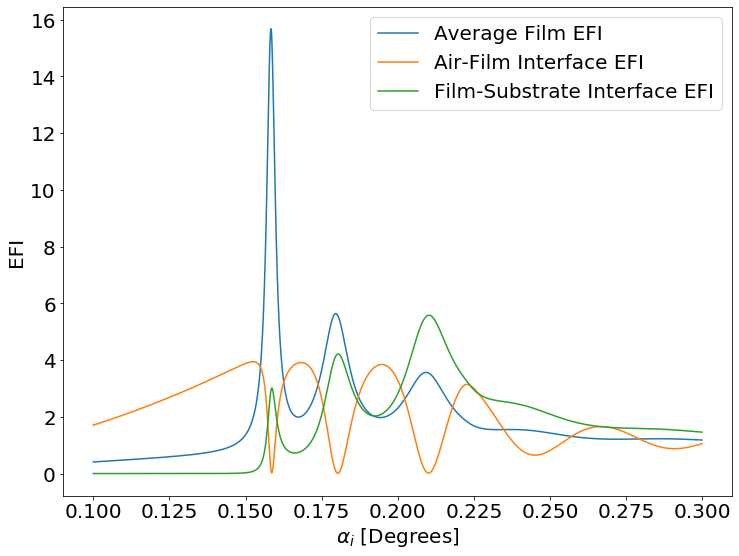

In [8]:
plt.figure(figsize=(12,9))
plt.plot(np.rad2deg(alpha_fine),np.mean(EFI_fine,axis=0),label='Average Film EFI')
plt.plot(np.rad2deg(alpha_fine),EFI_fine[50,:],label='Air-Film Interface EFI')
plt.plot(np.rad2deg(alpha_fine),EFI_fine[-50,:],label='Film-Substrate Interface EFI')
plt.legend(loc='upper right',fontsize=20)
plt.xlabel(r'$\alpha_i$ [Degrees]')
plt.ylabel('EFI')
plt.show()